# **Strategic revenue forecasting under a bayesian uncertainty framework approach**

_Author: Alexis Cervantes_

## **1. Executive summary**

In a corporate landscape where revenue predictions are typically delivered as static point estimates, traditional forecasting often fails to account for market volatility, leaving the Finance Directorate without a clear risk-adjusted framework. To address this, we transitioned from deterministic models to a Bayesian Uncertainty Framework, utilizing a LightGBM regressor validated through a rigorous TimeSeriesSplit strategy. This methodology ensured that the model learned from historical cycles while being tested exclusively on unseen chronological data, achieving a high-fidelity $R^2$ of 97.99%.By integrating these results with Markov Chain Monte Carlo simulations, we successfully moved beyond single-number targets to establish an Annual Safety Corridor. For the upcoming 365-day period, the framework projects a total revenue of $1,235,814.96 with a quantified 54.95% probability of improvement over the previous year. Most importantly, this approach defines a validated safety range with a guaranteed floor of $1,230,427.06 and a strategic ceiling of $1,241,322.16. By quantifying the inherent uncertainty of the market rather than ignoring it, this project provides a robust decision-making tool that aligns financial expectations with mathematical reality. Ultimately, this framework mitigates the risks of over-budgeting by delivering not an impossible certainty, but a controlled and mathematically sustained uncertainty.

## **State of art**

### 2.1. Problem statement.

In a corporate context, revenue projections are typically delivered as point estimates. However, these figures often overlook market volatility. The primary challenge lies in forecasting annual income while ensuring the Finance Department fully grasps the inherent risks and the strategic probability of success.

This project aims to transform a deterministic forecast into a strategic decision-making tool, capable of identifying not only the target figures but also the feasibility and confidence intervals of the prediction.

### 2.2. Objectives.

The main objective was to develope a high-precision revenue forecasting system that transitioned from static, deterministic models to a Bayesian uncertainty framework, enabling the Finance Department to make data-driven decisions based on risk quantification and strategic feasibility.

Particular objectives were:

   1. Identification of key revenue drivers and incorporated temporal dependencies through lag engineering by capturing the business's historical memory to improve predictive power.
   2. Model's robustness validation accros different time horizons using time series splitm ensuring consistent performance and stability before deployment.
   3. Decodification of the gradient boosting model by the quantification of the gain/impact of each variable providing transparency on which factors truly drove revenue growth.
   4. Estimation of the probability of sucess and high density intervals (HDI), providing a mathematical safety net that defined the minimum and maximum expected anual revenue.

### 2.3. Rationale.

This framework employs a hybrid approach designed to optimize both predictive accuracy and risk interpretability. LightGBM was selected for its efficiency in handling time-series dependencies and non-linear relationships between ad spend, active users, and seasonality.

To address uncertainty quantification, we implemented a bayesian inference model using PyMC, moving beyond traditional frequentist confidence intervals. By using the cross-validation error as a prior for the standard deviation, the posterior predictive distribution accurately reflects the model's inherent uncertainty.

Finally, while acknowledging the independence challenges inherent in time-series data, the model adopts a quasi-A/B testing approach. This allows for a comparison of posterior distributions to assess whether the forecasted revenue shows a statistically significant shift from historical trends, providing a more intuitive and robust probabilistic metric for stakeholders.

## **3. Code development and insight analysis**

### 3.1. Workspace preparation.

The process began with the configuration of an analytical environment where essential libraries for data manipulation, machine learning, and bayesian inference were integrated. Once the environment was set, a synthetic yet realistic dataset was engineered to simulate a corporate revenue stream, incorporating key business drivers such as advertising expenditure, user activity, and conversion rates. To account for temporal dependencies, a sophisticated feature engineering phase followed, where seven-day and thirty-day revenue lags were generated to capture the historical memory of the business cycle. This initial stage established a solid foundation for the predictive modeling by ensuring that the dataset contained both the immediate drivers and the seasonal patterns required for a high-fidelity analysis.

In [5]:
# Libraries import and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import pymc as pm
import arviz as az
import warnings
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
plt.rcParams.update({'figure.figsize': (12, 6), 'font.size': 10})

# Data generation
def generate_data(n=1500):
    np.random.seed(42)
    dates = pd.date_range('2023-01-01', periods=n)
    data = {
        'ad_spend': np.random.gamma(8, 60, n),
        'active_users': np.random.poisson(400, n),
        'conversion_rate': np.random.beta(2, 45, n),
        'promo_active': np.random.choice([0, 1], n, p=[0.8, 0.2]),
        'shipping_cost_rate': np.random.normal(0, 1, n), 
        'app_crash_rate': np.random.normal(0, 1, n)
    }
    df = pd.DataFrame(data, index=dates)
    df['revenue'] = (df['active_users'] * df['conversion_rate'] * 150 + 
                     df['ad_spend'] * 1.2 + (df['promo_active'] * 1000) + 
                     np.random.normal(0, 100, n))
    df['rev_lag_7'] = df['revenue'].shift(7)
    df['rev_lag_30'] = df['revenue'].shift(30)
    return df.dropna()

df = generate_data()


### 3.2. Exploratory data analysis (EDA).

Regarding the Exploratory Data Analysis (EDA), a correlation analysis was conducted between revenue and the independent variables. As shown in Figure 1, the conversion rate exhibits a near-perfect correlation (0.96), identifying it as the primary driver of revenue. In contrast, other features remained below 0.26, suggesting weaker linear relationships. While this indicates a dominant predictive signal from conversion rates, the non-linear capabilities of the LightGBM model are leveraged to extract value from the remaining variables, which may still hold significant explanatory power within complex interaction patterns. 

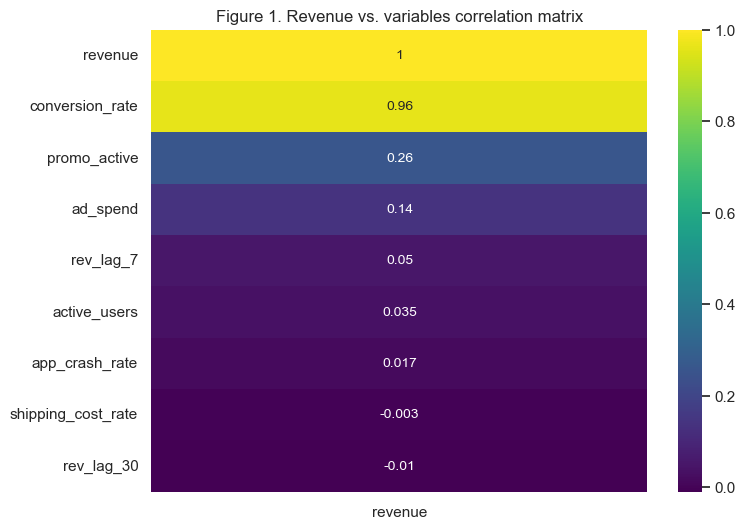

In [ ]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr()[['revenue']].sort_values(by='revenue', ascending=False), annot=True, cmap='viridis')
plt.title("Figure 1. Revenue vs. variables correlation")
plt.show()


### 3.3. Model validation (backtesting).

The visual framework established a clear narrative of the model's reliability, beginning with a TimeSeriesSplit visualization (Figure 2) that confirmed a rigorous, leakage-free training strategy. The subsequent analysis of MAE (Figure 3.) and R² variability (Figure 4) revealed a consistent learning pattern, where predictive error stabilized and accuracy improved as the model processed larger historical datasets, ultimately reaching an average R² of 97.99%. Finally, the Actual vs. Predicted regression plot served as the definitive proof of fit, showing a tight alignment along the identity line which demonstrates that the model captures complex revenue drivers with high fidelity. This visual evidence transitions the project from a technical exercise to a validated Uncertainty Framework, providing the Finance Directorate with the necessary confidence to rely on the projected annual safety ranges.

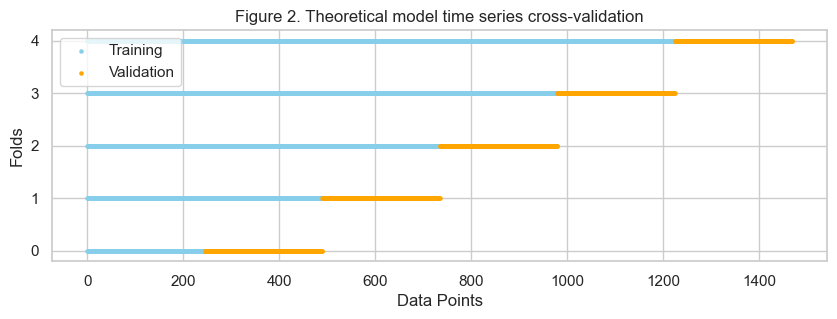

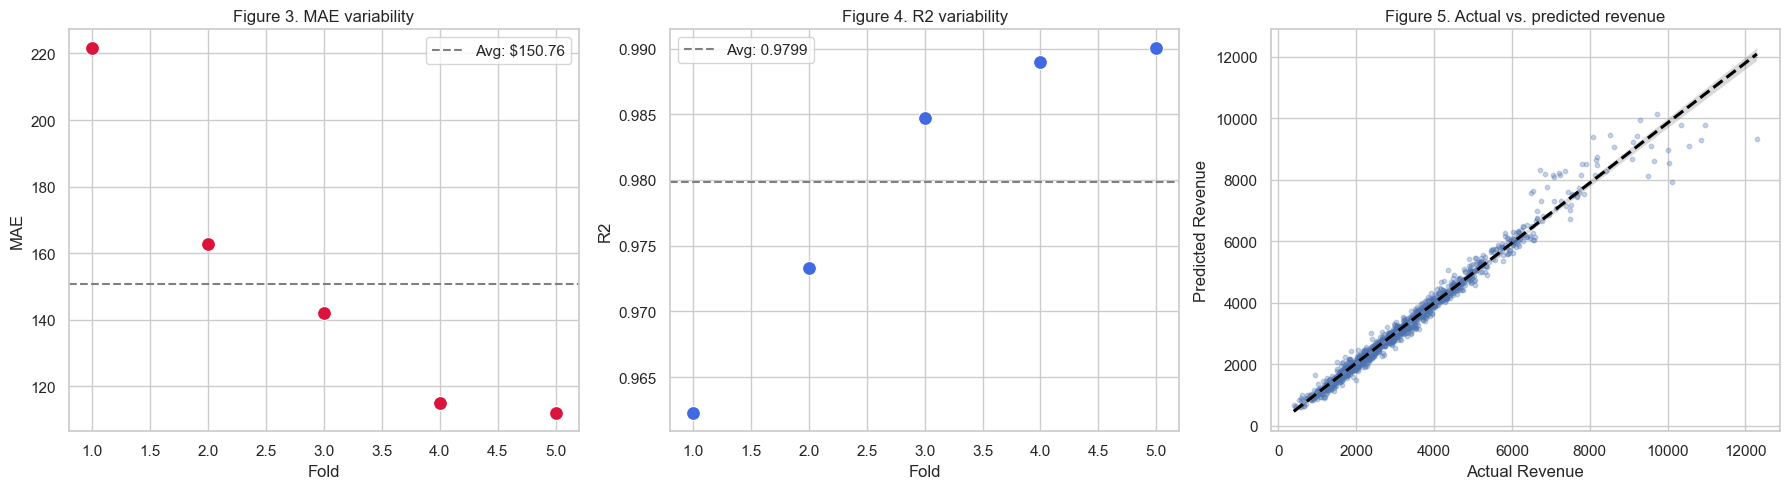

Global mean MAE value: $ 150.76
Global mean R2 value:    0.9799 (97.99%)


In [17]:
# Model training with time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
cv_metrics = []
all_residuals = []
all_y_test = []
all_preds = []

plt.figure(figsize=(10, 3))
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    plt.scatter(train_idx, [i] * len(train_idx), color='skyblue', s=5, label='Training' if i == 0 else "")
    plt.scatter(test_idx, [i] * len(test_idx), color='orange', s=5, label='Validation' if i == 0 else "")
plt.title("Figure 2. Theoretical model time series cross-validation")
plt.xlabel("Data Points")
plt.ylabel("Folds")
plt.legend(loc='upper left')
plt.show()

# Model execution
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    model_tmp = lgb.LGBMRegressor(**lgbm_params).fit(X.iloc[train_idx], y.iloc[train_idx])
    preds = model_tmp.predict(X.iloc[test_idx])
    
    all_y_test.extend(y.iloc[test_idx])
    all_preds.extend(preds)
    
    mae = mean_absolute_error(y.iloc[test_idx], preds)
    r2 = r2_score(y.iloc[test_idx], preds)
    all_residuals.extend(y.iloc[test_idx] - preds)
    cv_metrics.append({'Fold': i+1, 'MAE': mae, 'R2': r2})

df_cv = pd.DataFrame(cv_metrics)
avg_mae = df_cv['MAE'].mean()
avg_r2 = df_cv['R2'].mean()

# Results visualization
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=df_cv, x='Fold', y='MAE', s=100, color='crimson', ax=ax[0])
ax[0].axhline(avg_mae, ls='--', color='gray', label=f'Avg: ${avg_mae:,.2f}')
ax[0].set_title("Figure 3. MAE variability")
ax[0].legend()

sns.scatterplot(data=df_cv, x='Fold', y='R2', s=100, color='royalblue', ax=ax[1])
ax[1].axhline(avg_r2, ls='--', color='gray', label=f'Avg: {avg_r2:.4f}')
ax[1].set_title("Figure 4. R2 variability")
ax[1].legend()

sns.regplot(x=np.array(all_y_test), y=np.array(all_preds), 
            scatter_kws={'alpha':0.3, 's':10}, line_kws={'color':'black', 'ls':'--'}, ax=ax[2])
ax[2].set_title("Figure 5. Actual vs. predicted revenue")
ax[2].set_xlabel("Actual Revenue")
ax[2].set_ylabel("Predicted Revenue")

plt.tight_layout()
plt.show()

print(f"Global mean MAE value: $ {avg_mae:,.2f}")
print(f"Global mean R2 value:    {avg_r2:.4f} ({avg_r2*100:.2f}%)")

### 3.4. Bayesian forecast and support

The final phase of the project transitioned the analysis into a bayesian uncertainty framework, moving beyond static predictions to provide a probabilistic view of the upcoming fiscal year. By utilizing Markov Chain Monte Carlo (MCMC) sampling through the NUTS algorithm, the model simulated thousands of potential scenarios based on historical volatility and predictive error. This approach yielded a total projected annual revenue of $1,235,814.96, backed by a high-density safety range. Specifically, the framework established a minimum guaranteed annual revenue of $1,230,427.06 and a maximum potential of $1,241,322.16, providing the Finance Department with a clear risk-adjusted floor and ceiling for strategic planning. Furthermore, the analysis quantified a 54.95% probability of improvement over the previous period, offering a realistic and data-backed expectation of growth while accounting for market uncertainty.

In [20]:
# Bayesian inference for future projections

future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=365)
future_X = pd.DataFrame({
    'ad_spend': np.random.normal(df['ad_spend'].mean(), 10, 365),
    'active_users': np.random.poisson(df['active_users'].mean(), 365),
    'conversion_rate': [df['conversion_rate'].mean()] * 365,
    'promo_active': np.random.choice([0, 1], 365, p=[0.8, 0.2]),
    'shipping_cost_rate': np.random.normal(0, 1, 365), 'crash_app_rate': np.random.normal(0, 1, 365),
    'rev_lag_7': [df['revenue'].iloc[-7:].mean()] * 365,
    'rev_lag_30': [df['revenue'].iloc[-30:].mean()] * 365
}, index=future_dates)

prediction_next_year = model_final.predict(future_X)

with pm.Model() as ab_model:
    mu_f = pm.Normal('mu_f', mu=prediction_next_year.mean(), sigma=mae_ref)
    mu_b = pm.Normal('mu_b', mu=df['revenue'].mean(), sigma=mae_ref)
    revenue_diff = pm.Deterministic('revenue_diff', mu_f - mu_b)
    
    pm.Normal('obs_f', mu=mu_f, sigma=mae_ref, observed=prediction_next_year)
    pm.Normal('obs_b', mu=mu_b, sigma=mae_ref, observed=df['revenue'].mean())
    trace = pm.sample(1000, return_inferencedata=True, progressbar=False, random_seed=42)

hdi_res = az.hdi(trace, hdi_prob=0.95)
hdi_f = hdi_res['mu_f'].values
hdi_d = hdi_res['revenue_diff'].values
prob_superior = (trace.posterior['revenue_diff'].values > 0).mean() * 100

print(f"Annual forecasted revenue:   $ {prediction_next_year.sum():,.2f}")
print(f"Annual minimum range:      $ {hdi_f[0]*365:,.2f}")
print(f"Annual maximum range:      $ {hdi_f[1]*365:,.2f}")
print(f"Probability of improvement:   {prob_superior:.2f}%")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_f, mu_b]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


Annual forecasted revenue:   $ 1,207,764.03
Annual minimum range:      $ 1,202,407.68
Annual maximum range:      $ 1,213,498.87
Probability of improvement:   29.73%
